## 1. Setup and Imports

In [1]:
!pip install torch tensorflow scikit-learn pandas matplotlib seaborn

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import time
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.8.0+cu126
Device available: CUDA


## 2. Set Random Seeds for Reproducibility

In [3]:
#Setting random seeds for reproductibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 3. Configuration Parameters

In [4]:
#Model Configuration
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.4
BATCH_SIZE = 32
NUM_EPOCHS = 10

#Device used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 4. Data Loading and Preprocessing

In [5]:
def load_and_preprocess_data(max_length):
    #Loading data using top 10000 words
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

    #Padding and truncating sequences
    x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
    x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

    return x_train, y_train, x_test, y_test

#Loading test data
x_train_sample, y_train_sample, x_test_sample, y_test_sample = load_and_preprocess_data(50)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 5. Custom Dataset Class

In [6]:
class IMDbDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

## 6. Model Architecture

In [7]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers,
                 dropout, activation='relu', architecture='rnn', bidirectional=False):
        super(SentimentRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.architecture = architecture

        #Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        #RNN layers
        if architecture == 'rnn':
            self.rnn = nn.RNN(
                embedding_dim, hidden_size, num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
        elif architecture == 'lstm':
            self.rnn = nn.LSTM(
                embedding_dim, hidden_size, num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
        elif architecture == 'bilstm':
            self.rnn = nn.LSTM(
                embedding_dim, hidden_size, num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=True
            )

        #Dropout
        self.dropout = nn.Dropout(dropout)

        #Activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()

        #Fully connected layers
        fc_input_size = hidden_size * 2 if (bidirectional or architecture == 'bilstm') else hidden_size
        self.fc1 = nn.Linear(fc_input_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #Embedding
        embedded = self.embedding(x)

        #RNN layers
        if self.architecture in ['lstm', 'bilstm']:
            output, (hidden, cell) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)

        #Using the last hidden state
        if self.bidirectional or self.architecture == 'bilstm':
            #Concatenating forward and backward hidden states
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        #Fully connected layers with dropout and activation
        out = self.dropout(hidden)
        out = self.fc1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)

        return out.squeeze()

In [8]:
#Creating test model
test_model = SentimentRNN(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    activation='relu',
    architecture='lstm'
)

print("Model Architecture:")
print(test_model)
print(f"\nTotal parameters: {sum(p.numel() for p in test_model.parameters()):,}")

Model Architecture:
SentimentRNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (rnn): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (activation): ReLU()
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 1,080,001


## 7. Training and Evaluation Functions

In [9]:
def train_model(model, train_loader, criterion, optimizer, device, use_grad_clip=False):
    model.train()
    total_loss = 0
    start_time = time.time()

    for sequences, labels in tqdm(train_loader, desc="Training", leave=False):
        sequences, labels = sequences.to(device), labels.to(device)

        #Forward pass
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        #Backward pass
        loss.backward()

        #Gradient clipping
        if use_grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

    epoch_time = time.time() - start_time
    avg_loss = total_loss / len(train_loader)

    return avg_loss, epoch_time

In [10]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            sequences = sequences.to(device)
            outputs = model(sequences)
            preds = (outputs > 0.5).float().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    return accuracy, f1

## 8. Main Experiment Function

In [11]:
def run_experiment(architecture, activation, optimizer_name, seq_length,
                   use_grad_clip, device, verbose=True):
    if verbose:
        print(f"Running: {architecture.upper()} | {activation} | {optimizer_name.upper()} | SeqLen={seq_length} | GradClip={use_grad_clip}")

    x_train, y_train, x_test, y_test = load_and_preprocess_data(seq_length)

    train_dataset = IMDbDataset(x_train, y_train)
    test_dataset = IMDbDataset(x_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = SentimentRNN(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        activation=activation,
        architecture=architecture,
        bidirectional=(architecture == 'bilstm')
    ).to(device)

    criterion = nn.BCELoss()

    if optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)

    train_losses = []
    train_times = []

    for epoch in range(NUM_EPOCHS):
        train_loss, epoch_time = train_model(
            model, train_loader, criterion, optimizer, device, use_grad_clip
        )
        train_losses.append(train_loss)
        train_times.append(epoch_time)

        if verbose and (epoch + 1) % 2 == 0:
            accuracy, f1 = evaluate_model(model, test_loader, device)
            print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | "
                  f"Acc: {accuracy:.4f} | F1: {f1:.4f} | Time: {epoch_time:.2f}s")

    final_accuracy, final_f1 = evaluate_model(model, test_loader, device)
    avg_epoch_time = np.mean(train_times)

    if verbose:
        print(f"\nFinal Results - Accuracy: {final_accuracy:.4f} | F1: {final_f1:.4f} | Avg Epoch Time: {avg_epoch_time:.2f}s")

    result = {
        'Model': architecture.upper(),
        'Activation': activation,
        'Optimizer': optimizer_name.upper(),
        'Seq_Length': seq_length,
        'Grad_Clipping': 'Yes' if use_grad_clip else 'No',
        'Accuracy': final_accuracy,
        'F1': final_f1,
        'Epoch_Time': avg_epoch_time,
        'train_losses': train_losses
    }

    return result

## 9. Run All Experiments

In [12]:
#Defining all experimental configurations
experiments = [
    #Baseline experiments with different architectures
    ('rnn', 'relu', 'adam', 50, False),
    ('lstm', 'relu', 'adam', 50, False),
    ('bilstm', 'relu', 'adam', 50, False),

    #Activation function variations (using RNN)
    ('rnn', 'sigmoid', 'adam', 50, False),
    ('rnn', 'tanh', 'adam', 50, False),

    #Optimizer variations (using RNN)
    ('rnn', 'relu', 'sgd', 50, False),
    ('rnn', 'relu', 'rmsprop', 50, False),

    #Sequence length variations (using RNN)
    ('rnn', 'relu', 'adam', 25, False),
    ('rnn', 'relu', 'adam', 100, False),

    #Activation function variations (using LSTM)
    ('lstm', 'sigmoid', 'adam', 50, False),
    ('lstm', 'tanh', 'adam', 50, False),

    #Optimizer variations (using LSTM)
    ('lstm', 'relu', 'sgd', 50, False),
    ('lstm', 'relu', 'rmsprop', 50, False),

    #Sequence length variations (using LSTM)
    ('lstm', 'relu', 'adam', 25, False),
    ('lstm', 'relu', 'adam', 100, False),

    #Activation function variations (using BILSTM)
    ('bilstm', 'sigmoid', 'adam', 50, False),
    ('bilstm', 'tanh', 'adam', 50, False),

    #Optimizer variations (using BILSTM)
    ('bilstm', 'relu', 'sgd', 50, False),
    ('bilstm', 'relu', 'rmsprop', 50, False),

    #Sequence length variations (using BILSTM)
    ('bilstm', 'relu', 'adam', 25, False),
    ('bilstm', 'relu', 'adam', 100, False),

    #Gradient clipping variations
    ('lstm', 'relu', 'adam', 50, True),
    ('rnn', 'relu', 'adam', 50, True),
    ('bilstm', 'relu', 'adam', 50, True)

]

print(f"Total experiments to run: {len(experiments)}")
print("\nExperiment configurations:")
for i, config in enumerate(experiments, 1):
    arch, act, opt, seq, clip = config
    print(f"{i:2d}. {arch.upper():7s} | {act:7s} | {opt.upper():7s} | SeqLen={seq:3d} | GradClip={clip}")

Total experiments to run: 24

Experiment configurations:
 1. RNN     | relu    | ADAM    | SeqLen= 50 | GradClip=False
 2. LSTM    | relu    | ADAM    | SeqLen= 50 | GradClip=False
 3. BILSTM  | relu    | ADAM    | SeqLen= 50 | GradClip=False
 4. RNN     | sigmoid | ADAM    | SeqLen= 50 | GradClip=False
 5. RNN     | tanh    | ADAM    | SeqLen= 50 | GradClip=False
 6. RNN     | relu    | SGD     | SeqLen= 50 | GradClip=False
 7. RNN     | relu    | RMSPROP | SeqLen= 50 | GradClip=False
 8. RNN     | relu    | ADAM    | SeqLen= 25 | GradClip=False
 9. RNN     | relu    | ADAM    | SeqLen=100 | GradClip=False
10. LSTM    | sigmoid | ADAM    | SeqLen= 50 | GradClip=False
11. LSTM    | tanh    | ADAM    | SeqLen= 50 | GradClip=False
12. LSTM    | relu    | SGD     | SeqLen= 50 | GradClip=False
13. LSTM    | relu    | RMSPROP | SeqLen= 50 | GradClip=False
14. LSTM    | relu    | ADAM    | SeqLen= 25 | GradClip=False
15. LSTM    | relu    | ADAM    | SeqLen=100 | GradClip=False
16. BILSTM  |

In [13]:
#Running all experiments
results = []

for i, config in enumerate(experiments, 1):
    print(f"\nEXPERIMENT {i}/{len(experiments)}\n")

    try:
        result = run_experiment(*config, device, verbose=True)
        results.append(result)
    except Exception as e:
        print(f"Error in experiment {config}: {str(e)}")
        continue

print(f"\nCOMPLETED {len(results)} out of {len(experiments)} EXPERIMENTS\n")


EXPERIMENT 1/24

Running: RNN | relu | ADAM | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.6867 | Acc: 0.5645 | F1: 0.5594 | Time: 2.29s


Epoch 4/10 | Loss: 0.6817 | Acc: 0.5612 | F1: 0.5569 | Time: 2.74s


Epoch 6/10 | Loss: 0.6375 | Acc: 0.6309 | F1: 0.6169 | Time: 2.28s


Epoch 8/10 | Loss: 0.5766 | Acc: 0.6667 | F1: 0.6667 | Time: 2.46s


Epoch 10/10 | Loss: 0.5596 | Acc: 0.6584 | F1: 0.6563 | Time: 2.27s



Final Results - Accuracy: 0.6584 | F1: 0.6563 | Avg Epoch Time: 2.44s

EXPERIMENT 2/24

Running: LSTM | relu | ADAM | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.6101 | Acc: 0.6616 | F1: 0.6382 | Time: 2.63s


Epoch 4/10 | Loss: 0.4575 | Acc: 0.7426 | F1: 0.7419 | Time: 2.66s


Epoch 6/10 | Loss: 0.3533 | Acc: 0.7498 | F1: 0.7483 | Time: 2.94s


Epoch 8/10 | Loss: 0.2717 | Acc: 0.7415 | F1: 0.7415 | Time: 2.90s


Epoch 10/10 | Loss: 0.2111 | Acc: 0.7413 | F1: 0.7413 | Time: 2.60s



Final Results - Accuracy: 0.7413 | F1: 0.7413 | Avg Epoch Time: 2.82s

EXPERIMENT 3/24

Running: BILSTM | relu | ADAM | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.4786 | Acc: 0.7548 | F1: 0.7548 | Time: 3.27s


Epoch 4/10 | Loss: 0.3283 | Acc: 0.7589 | F1: 0.7587 | Time: 3.92s


Epoch 6/10 | Loss: 0.2043 | Acc: 0.7540 | F1: 0.7539 | Time: 3.27s


Epoch 8/10 | Loss: 0.1043 | Acc: 0.7474 | F1: 0.7473 | Time: 3.28s


Epoch 10/10 | Loss: 0.0639 | Acc: 0.7424 | F1: 0.7420 | Time: 3.95s



Final Results - Accuracy: 0.7424 | F1: 0.7420 | Avg Epoch Time: 3.54s

EXPERIMENT 4/24

Running: RNN | sigmoid | ADAM | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.6860 | Acc: 0.5278 | F1: 0.4951 | Time: 2.42s


Epoch 4/10 | Loss: 0.6823 | Acc: 0.5785 | F1: 0.5781 | Time: 2.29s


Epoch 6/10 | Loss: 0.6589 | Acc: 0.6086 | F1: 0.6077 | Time: 2.28s


Epoch 8/10 | Loss: 0.6115 | Acc: 0.6020 | F1: 0.5935 | Time: 2.28s


Epoch 10/10 | Loss: 0.6136 | Acc: 0.6224 | F1: 0.6140 | Time: 2.26s



Final Results - Accuracy: 0.6224 | F1: 0.6140 | Avg Epoch Time: 2.35s

EXPERIMENT 5/24

Running: RNN | tanh | ADAM | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.6845 | Acc: 0.5384 | F1: 0.4331 | Time: 2.26s


Epoch 4/10 | Loss: 0.6680 | Acc: 0.6211 | F1: 0.6090 | Time: 2.77s


Epoch 6/10 | Loss: 0.6246 | Acc: 0.6188 | F1: 0.6173 | Time: 2.27s


Epoch 8/10 | Loss: 0.6235 | Acc: 0.6424 | F1: 0.6416 | Time: 2.62s


Epoch 10/10 | Loss: 0.5895 | Acc: 0.6418 | F1: 0.6416 | Time: 2.24s



Final Results - Accuracy: 0.6418 | F1: 0.6416 | Avg Epoch Time: 2.35s

EXPERIMENT 6/24

Running: RNN | relu | SGD | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.6935 | Acc: 0.5071 | F1: 0.4068 | Time: 2.04s


Epoch 4/10 | Loss: 0.6869 | Acc: 0.5794 | F1: 0.5721 | Time: 2.06s


Epoch 6/10 | Loss: 0.6875 | Acc: 0.5626 | F1: 0.5537 | Time: 2.55s


Epoch 8/10 | Loss: 0.6903 | Acc: 0.5464 | F1: 0.5462 | Time: 2.10s


Epoch 10/10 | Loss: 0.6924 | Acc: 0.5115 | F1: 0.4704 | Time: 2.16s



Final Results - Accuracy: 0.5115 | F1: 0.4704 | Avg Epoch Time: 2.17s

EXPERIMENT 7/24

Running: RNN | relu | RMSPROP | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.6885 | Acc: 0.5040 | F1: 0.3510 | Time: 2.23s


Epoch 4/10 | Loss: 0.6535 | Acc: 0.6338 | F1: 0.6297 | Time: 2.24s


Epoch 6/10 | Loss: 0.5936 | Acc: 0.6690 | F1: 0.6688 | Time: 2.31s


Epoch 8/10 | Loss: 0.5593 | Acc: 0.6855 | F1: 0.6788 | Time: 2.51s


Epoch 10/10 | Loss: 0.5139 | Acc: 0.6430 | F1: 0.6392 | Time: 2.24s



Final Results - Accuracy: 0.6430 | F1: 0.6392 | Avg Epoch Time: 2.36s

EXPERIMENT 8/24

Running: RNN | relu | ADAM | SeqLen=25 | GradClip=False


Epoch 2/10 | Loss: 0.6615 | Acc: 0.6251 | F1: 0.6167 | Time: 2.34s


Epoch 4/10 | Loss: 0.5903 | Acc: 0.6490 | F1: 0.6486 | Time: 2.32s


Epoch 6/10 | Loss: 0.5164 | Acc: 0.6797 | F1: 0.6797 | Time: 2.33s


Epoch 8/10 | Loss: 0.4837 | Acc: 0.6802 | F1: 0.6800 | Time: 2.34s


Epoch 10/10 | Loss: 0.4256 | Acc: 0.6845 | F1: 0.6843 | Time: 2.32s



Final Results - Accuracy: 0.6845 | F1: 0.6843 | Avg Epoch Time: 2.41s

EXPERIMENT 9/24

Running: RNN | relu | ADAM | SeqLen=100 | GradClip=False


Epoch 2/10 | Loss: 0.6930 | Acc: 0.5215 | F1: 0.4558 | Time: 2.69s


Epoch 4/10 | Loss: 0.6712 | Acc: 0.5942 | F1: 0.5834 | Time: 2.37s


Epoch 6/10 | Loss: 0.6586 | Acc: 0.6322 | F1: 0.6314 | Time: 2.78s


Epoch 8/10 | Loss: 0.6006 | Acc: 0.6618 | F1: 0.6576 | Time: 2.36s


Epoch 10/10 | Loss: 0.5792 | Acc: 0.6584 | F1: 0.6582 | Time: 2.89s



Final Results - Accuracy: 0.6584 | F1: 0.6582 | Avg Epoch Time: 2.55s

EXPERIMENT 10/24

Running: LSTM | sigmoid | ADAM | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.5957 | Acc: 0.7050 | F1: 0.7036 | Time: 2.91s


Epoch 4/10 | Loss: 0.4625 | Acc: 0.7435 | F1: 0.7435 | Time: 2.64s


Epoch 6/10 | Loss: 0.3684 | Acc: 0.7450 | F1: 0.7449 | Time: 3.12s


Epoch 8/10 | Loss: 0.2869 | Acc: 0.7516 | F1: 0.7516 | Time: 2.60s


Epoch 10/10 | Loss: 0.2196 | Acc: 0.7490 | F1: 0.7488 | Time: 3.16s



Final Results - Accuracy: 0.7490 | F1: 0.7488 | Avg Epoch Time: 2.75s

EXPERIMENT 11/24

Running: LSTM | tanh | ADAM | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.5217 | Acc: 0.7435 | F1: 0.7429 | Time: 2.74s


Epoch 4/10 | Loss: 0.3641 | Acc: 0.7577 | F1: 0.7577 | Time: 2.58s


Epoch 6/10 | Loss: 0.2538 | Acc: 0.7534 | F1: 0.7534 | Time: 3.03s


Epoch 8/10 | Loss: 0.1699 | Acc: 0.7476 | F1: 0.7475 | Time: 2.61s


Epoch 10/10 | Loss: 0.1238 | Acc: 0.7451 | F1: 0.7451 | Time: 3.18s



Final Results - Accuracy: 0.7451 | F1: 0.7451 | Avg Epoch Time: 2.74s

EXPERIMENT 12/24

Running: LSTM | relu | SGD | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.6935 | Acc: 0.4999 | F1: 0.3339 | Time: 2.43s


Epoch 4/10 | Loss: 0.6935 | Acc: 0.5215 | F1: 0.5117 | Time: 2.42s


Epoch 6/10 | Loss: 0.6929 | Acc: 0.5000 | F1: 0.3333 | Time: 2.43s


Epoch 8/10 | Loss: 0.6912 | Acc: 0.5409 | F1: 0.5340 | Time: 2.41s


Epoch 10/10 | Loss: 0.6809 | Acc: 0.6205 | F1: 0.6195 | Time: 2.44s



Final Results - Accuracy: 0.6205 | F1: 0.6195 | Avg Epoch Time: 2.49s

EXPERIMENT 13/24

Running: LSTM | relu | RMSPROP | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.5620 | Acc: 0.6305 | F1: 0.5909 | Time: 2.56s


Epoch 4/10 | Loss: 0.4216 | Acc: 0.7478 | F1: 0.7467 | Time: 2.52s


Epoch 6/10 | Loss: 0.3253 | Acc: 0.7195 | F1: 0.7076 | Time: 2.56s


Epoch 8/10 | Loss: 0.2337 | Acc: 0.7462 | F1: 0.7448 | Time: 2.57s


Epoch 10/10 | Loss: 0.1565 | Acc: 0.7514 | F1: 0.7512 | Time: 2.60s



Final Results - Accuracy: 0.7514 | F1: 0.7512 | Avg Epoch Time: 2.68s

EXPERIMENT 14/24

Running: LSTM | relu | ADAM | SeqLen=25 | GradClip=False


Epoch 2/10 | Loss: 0.5492 | Acc: 0.6991 | F1: 0.6971 | Time: 2.64s


Epoch 4/10 | Loss: 0.4037 | Acc: 0.7064 | F1: 0.7059 | Time: 2.68s


Epoch 6/10 | Loss: 0.2737 | Acc: 0.7009 | F1: 0.7008 | Time: 2.68s


Epoch 8/10 | Loss: 0.1800 | Acc: 0.6902 | F1: 0.6893 | Time: 2.67s


Epoch 10/10 | Loss: 0.1204 | Acc: 0.6836 | F1: 0.6832 | Time: 2.67s



Final Results - Accuracy: 0.6836 | F1: 0.6832 | Avg Epoch Time: 2.79s

EXPERIMENT 15/24

Running: LSTM | relu | ADAM | SeqLen=100 | GradClip=False


Epoch 2/10 | Loss: 0.6474 | Acc: 0.5412 | F1: 0.4379 | Time: 2.77s


Epoch 4/10 | Loss: 0.4361 | Acc: 0.7939 | F1: 0.7937 | Time: 2.77s


Epoch 6/10 | Loss: 0.2900 | Acc: 0.8136 | F1: 0.8136 | Time: 2.75s


Epoch 8/10 | Loss: 0.1934 | Acc: 0.8065 | F1: 0.8057 | Time: 2.79s


Epoch 10/10 | Loss: 0.1230 | Acc: 0.8059 | F1: 0.8058 | Time: 3.18s



Final Results - Accuracy: 0.8059 | F1: 0.8058 | Avg Epoch Time: 2.92s

EXPERIMENT 16/24

Running: BILSTM | sigmoid | ADAM | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.5308 | Acc: 0.7237 | F1: 0.7202 | Time: 4.08s


Epoch 4/10 | Loss: 0.3700 | Acc: 0.7574 | F1: 0.7568 | Time: 3.30s


Epoch 6/10 | Loss: 0.2528 | Acc: 0.7514 | F1: 0.7513 | Time: 3.35s


Epoch 8/10 | Loss: 0.1593 | Acc: 0.7430 | F1: 0.7429 | Time: 3.98s


Epoch 10/10 | Loss: 0.0973 | Acc: 0.7433 | F1: 0.7432 | Time: 3.36s



Final Results - Accuracy: 0.7433 | F1: 0.7432 | Avg Epoch Time: 3.55s

EXPERIMENT 17/24

Running: BILSTM | tanh | ADAM | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.4820 | Acc: 0.7532 | F1: 0.7531 | Time: 3.35s


Epoch 4/10 | Loss: 0.3264 | Acc: 0.7538 | F1: 0.7537 | Time: 3.36s


Epoch 6/10 | Loss: 0.2024 | Acc: 0.7479 | F1: 0.7479 | Time: 4.07s


Epoch 8/10 | Loss: 0.1193 | Acc: 0.7473 | F1: 0.7473 | Time: 3.32s


Epoch 10/10 | Loss: 0.0781 | Acc: 0.7447 | F1: 0.7447 | Time: 3.43s



Final Results - Accuracy: 0.7447 | F1: 0.7447 | Avg Epoch Time: 3.56s

EXPERIMENT 18/24

Running: BILSTM | relu | SGD | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.6927 | Acc: 0.5046 | F1: 0.3557 | Time: 3.13s


Epoch 4/10 | Loss: 0.6907 | Acc: 0.5546 | F1: 0.5495 | Time: 3.77s


Epoch 6/10 | Loss: 0.6730 | Acc: 0.6038 | F1: 0.6004 | Time: 3.08s


Epoch 8/10 | Loss: 0.6052 | Acc: 0.6790 | F1: 0.6692 | Time: 3.20s


Epoch 10/10 | Loss: 0.5360 | Acc: 0.7282 | F1: 0.7282 | Time: 3.17s



Final Results - Accuracy: 0.7282 | F1: 0.7282 | Avg Epoch Time: 3.31s

EXPERIMENT 19/24

Running: BILSTM | relu | RMSPROP | SeqLen=50 | GradClip=False


Epoch 2/10 | Loss: 0.4844 | Acc: 0.7335 | F1: 0.7288 | Time: 3.45s


Epoch 4/10 | Loss: 0.3512 | Acc: 0.7608 | F1: 0.7606 | Time: 3.26s


Epoch 6/10 | Loss: 0.2409 | Acc: 0.7492 | F1: 0.7480 | Time: 3.69s


Epoch 8/10 | Loss: 0.1371 | Acc: 0.7504 | F1: 0.7504 | Time: 3.26s


Epoch 10/10 | Loss: 0.0787 | Acc: 0.7486 | F1: 0.7486 | Time: 3.22s



Final Results - Accuracy: 0.7486 | F1: 0.7486 | Avg Epoch Time: 3.40s

EXPERIMENT 20/24

Running: BILSTM | relu | ADAM | SeqLen=25 | GradClip=False


Epoch 2/10 | Loss: 0.5241 | Acc: 0.7091 | F1: 0.7091 | Time: 3.35s


Epoch 4/10 | Loss: 0.3718 | Acc: 0.7007 | F1: 0.6996 | Time: 4.01s


Epoch 6/10 | Loss: 0.2167 | Acc: 0.6942 | F1: 0.6937 | Time: 3.35s


Epoch 8/10 | Loss: 0.1103 | Acc: 0.6851 | F1: 0.6846 | Time: 3.35s


Epoch 10/10 | Loss: 0.0624 | Acc: 0.6809 | F1: 0.6805 | Time: 4.05s



Final Results - Accuracy: 0.6809 | F1: 0.6805 | Avg Epoch Time: 3.58s

EXPERIMENT 21/24

Running: BILSTM | relu | ADAM | SeqLen=100 | GradClip=False


Epoch 2/10 | Loss: 0.5041 | Acc: 0.7631 | F1: 0.7604 | Time: 3.77s


Epoch 4/10 | Loss: 0.3600 | Acc: 0.7900 | F1: 0.7885 | Time: 3.94s


Epoch 6/10 | Loss: 0.2698 | Acc: 0.8051 | F1: 0.8051 | Time: 3.55s


Epoch 8/10 | Loss: 0.1839 | Acc: 0.7994 | F1: 0.7991 | Time: 3.46s


Epoch 10/10 | Loss: 0.1400 | Acc: 0.7992 | F1: 0.7992 | Time: 4.14s



Final Results - Accuracy: 0.7992 | F1: 0.7992 | Avg Epoch Time: 3.75s

EXPERIMENT 22/24

Running: LSTM | relu | ADAM | SeqLen=50 | GradClip=True


Epoch 2/10 | Loss: 0.5335 | Acc: 0.7383 | F1: 0.7371 | Time: 3.49s


Epoch 4/10 | Loss: 0.3778 | Acc: 0.7568 | F1: 0.7568 | Time: 2.91s


Epoch 6/10 | Loss: 0.2608 | Acc: 0.7492 | F1: 0.7491 | Time: 3.09s


Epoch 8/10 | Loss: 0.1705 | Acc: 0.7447 | F1: 0.7444 | Time: 2.95s


Epoch 10/10 | Loss: 0.1105 | Acc: 0.7470 | F1: 0.7469 | Time: 2.95s



Final Results - Accuracy: 0.7470 | F1: 0.7469 | Avg Epoch Time: 3.12s

EXPERIMENT 23/24

Running: RNN | relu | ADAM | SeqLen=50 | GradClip=True


Epoch 2/10 | Loss: 0.6749 | Acc: 0.5952 | F1: 0.5551 | Time: 2.67s


Epoch 4/10 | Loss: 0.6193 | Acc: 0.6551 | F1: 0.6525 | Time: 2.60s


Epoch 6/10 | Loss: 0.5636 | Acc: 0.6814 | F1: 0.6806 | Time: 2.64s


Epoch 8/10 | Loss: 0.5040 | Acc: 0.6828 | F1: 0.6804 | Time: 2.66s


Epoch 10/10 | Loss: 0.4468 | Acc: 0.7012 | F1: 0.7005 | Time: 2.63s



Final Results - Accuracy: 0.7012 | F1: 0.7005 | Avg Epoch Time: 2.75s

EXPERIMENT 24/24

Running: BILSTM | relu | ADAM | SeqLen=50 | GradClip=True


Epoch 2/10 | Loss: 0.4791 | Acc: 0.7522 | F1: 0.7522 | Time: 3.72s


Epoch 4/10 | Loss: 0.3250 | Acc: 0.7532 | F1: 0.7528 | Time: 4.36s


Epoch 6/10 | Loss: 0.1916 | Acc: 0.7551 | F1: 0.7548 | Time: 3.94s


Epoch 8/10 | Loss: 0.1015 | Acc: 0.7478 | F1: 0.7473 | Time: 3.64s


Epoch 10/10 | Loss: 0.0557 | Acc: 0.7468 | F1: 0.7467 | Time: 3.68s



Final Results - Accuracy: 0.7468 | F1: 0.7467 | Avg Epoch Time: 3.92s

COMPLETED 24 out of 24 EXPERIMENTS



## 10. Results Analysis

In [14]:
#Results table
df_results = pd.DataFrame(results)
print("\nSUMMARY OF ALL EXPERIMENTS\n")
print(df_results.to_string(index=False))

df_results.to_csv('experiment_results.csv', index=False)
print("\nResults saved to 'experiment_results.csv'")


SUMMARY OF ALL EXPERIMENTS

 Model Activation Optimizer  Seq_Length Grad_Clipping  Accuracy       F1  Epoch_Time                                                                                                                                                                                                    train_losses
   RNN       relu      ADAM          50            No   0.65836 0.656275    2.436890        [0.6939090730436622, 0.6867210309371314, 0.6918769454407265, 0.6817425365185799, 0.6478656223591637, 0.6375208648345659, 0.6069999305564729, 0.5766082438437835, 0.5525319349887731, 0.5596344040711517]
  LSTM       relu      ADAM          50            No   0.74132 0.741262    2.819317   [0.6735207336333097, 0.6100591406645373, 0.5250347963989238, 0.45751707962787974, 0.4032858581379856, 0.3533164529353761, 0.30047251194563057, 0.27171757252281886, 0.23741813085477828, 0.21114756977733443]
BILSTM       relu      ADAM          50            No   0.74240 0.742000    3.538914    [0.6

In [15]:
#Displaying best configuration
best_idx = df_results['Accuracy'].idxmax()
best = df_results.iloc[best_idx]

print("\nBEST CONFIGURATION\n")
print(f"Model:            {best['Model']}")
print(f"Activation:       {best['Activation']}")
print(f"Optimizer:        {best['Optimizer']}")
print(f"Sequence Length:  {best['Seq_Length']}")
print(f"Gradient Clipping: {best['Grad_Clipping']}")
print(f"\nAccuracy:         {best['Accuracy']:.4f}")
print(f"F1 Score:         {best['F1']:.4f}")
print(f"Epoch Time:       {best['Epoch_Time']:.2f}s")


BEST CONFIGURATION

Model:            LSTM
Activation:       relu
Optimizer:        ADAM
Sequence Length:  100
Gradient Clipping: No

Accuracy:         0.8059
F1 Score:         0.8058
Epoch Time:       2.92s


In [16]:
#Statistical summary
print("\nStatistical Summary:\n")
print(df_results[['Accuracy', 'F1', 'Epoch_Time']].describe())


Statistical Summary:

        Accuracy         F1  Epoch_Time
count  24.000000  24.000000   24.000000
mean    0.704127   0.701638    2.929323
std     0.066439   0.072560    0.520185
min     0.511480   0.470448    2.172107
25%     0.658390   0.657739    2.479629
50%     0.734740   0.734708    2.772683
75%     0.746880   0.746778    3.431589
max     0.805920   0.805828    3.916196


## 11. Visualizations

In [17]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

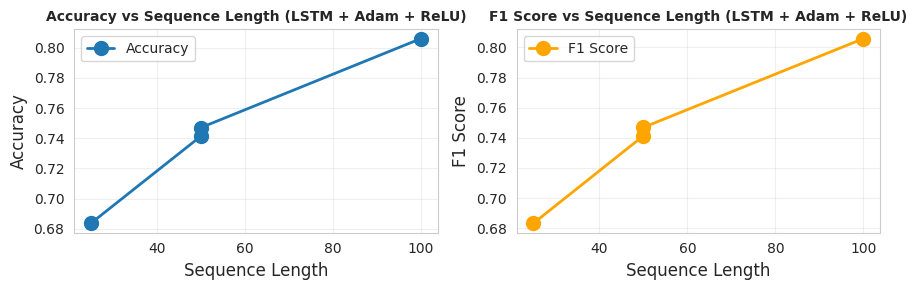

<Figure size 1500x1000 with 0 Axes>

Saved: accuracy_vs_seq_length.png


In [71]:
#Plot 1a: Accuracy vs Sequence Length
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

#Filtering data for LSTM with Adam optimizer
seq_data = df_results[(df_results['Model'] == 'LSTM') &
                      (df_results['Optimizer'] == 'ADAM') &
                      (df_results['Activation'] == 'relu')].sort_values('Seq_Length')

if len(seq_data) > 0:
    ax1.plot(seq_data['Seq_Length'], seq_data['Accuracy'], 'o-', linewidth=2, markersize=10, label='Accuracy')
    ax1.set_xlabel('Sequence Length', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Accuracy vs Sequence Length (LSTM + Adam + ReLU)', fontsize=10, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.plot(seq_data['Seq_Length'], seq_data['F1'], 'o-', color='orange', linewidth=2, markersize=10, label='F1 Score')
    ax2.set_xlabel('Sequence Length', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.set_title('F1 Score vs Sequence Length (LSTM + Adam + ReLU)', fontsize=10, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

plt.tight_layout()
plt.savefig('accuracy_vs_seq_length.png', dpi=300, bbox_inches='tight')
plt.show()

#Filtering data for LSTM with Adam optimizer
seq_data = df_results[(df_results['Model'] == 'LSTM') &
                      (df_results['Optimizer'] == 'ADAM') &
                      (df_results['Activation'] == 'relu')].sort_values('Seq_Length')

if len(seq_data) > 0:
    ax1.plot(seq_data['Seq_Length'], seq_data['Accuracy'], 'o-', linewidth=2, markersize=10, label='Accuracy')
    ax1.set_xlabel('Sequence Length', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Accuracy vs Sequence Length (LSTM + Adam + ReLU)', fontsize=10, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.plot(seq_data['Seq_Length'], seq_data['F1'], 'o-', color='orange', linewidth=2, markersize=10, label='F1 Score')
    ax2.set_xlabel('Sequence Length', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.set_title('F1 Score vs Sequence Length (LSTM + Adam + ReLU)', fontsize=10, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

plt.tight_layout()
plt.savefig('accuracy_vs_seq_length.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: accuracy_vs_seq_length.png")

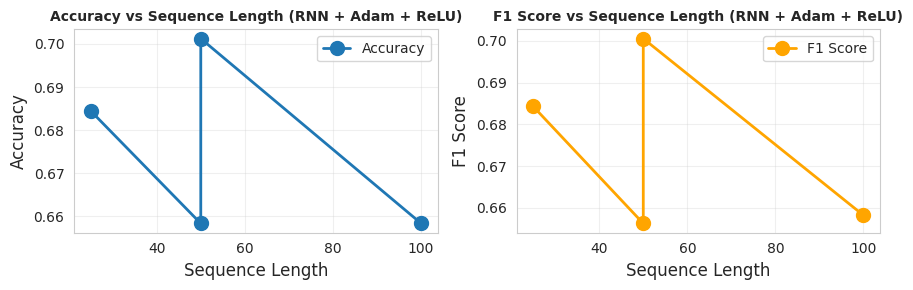

<Figure size 1500x1000 with 0 Axes>

Saved: accuracy_vs_seq_length.png


In [73]:
#Plot 1b: Accuracy vs Sequence Length
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

#Filtering data for RNN with Adam optimizer
seq_data = df_results[(df_results['Model'] == 'RNN') &
                      (df_results['Optimizer'] == 'ADAM') &
                      (df_results['Activation'] == 'relu')].sort_values('Seq_Length')

if len(seq_data) > 0:
    ax1.plot(seq_data['Seq_Length'], seq_data['Accuracy'], 'o-', linewidth=2, markersize=10, label='Accuracy')
    ax1.set_xlabel('Sequence Length', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Accuracy vs Sequence Length (RNN + Adam + ReLU)', fontsize=10, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.plot(seq_data['Seq_Length'], seq_data['F1'], 'o-', color='orange', linewidth=2, markersize=10, label='F1 Score')
    ax2.set_xlabel('Sequence Length', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.set_title('F1 Score vs Sequence Length (RNN + Adam + ReLU)', fontsize=10, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

plt.tight_layout()
plt.savefig('accuracy_vs_seq_length.png', dpi=300, bbox_inches='tight')
plt.show()

#Filtering data for RNN with Adam optimizer
seq_data = df_results[(df_results['Model'] == 'RNN') &
                      (df_results['Optimizer'] == 'ADAM') &
                      (df_results['Activation'] == 'relu')].sort_values('Seq_Length')

if len(seq_data) > 0:
    ax1.plot(seq_data['Seq_Length'], seq_data['Accuracy'], 'o-', linewidth=2, markersize=10, label='Accuracy')
    ax1.set_xlabel('Sequence Length', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Accuracy vs Sequence Length (RNN + Adam + ReLU)', fontsize=10, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.plot(seq_data['Seq_Length'], seq_data['F1'], 'o-', color='orange', linewidth=2, markersize=10, label='F1 Score')
    ax2.set_xlabel('Sequence Length', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.set_title('F1 Score vs Sequence Length (RNN + Adam + ReLU)', fontsize=10, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

plt.tight_layout()
plt.savefig('accuracy_vs_seq_length.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: accuracy_vs_seq_length.png")

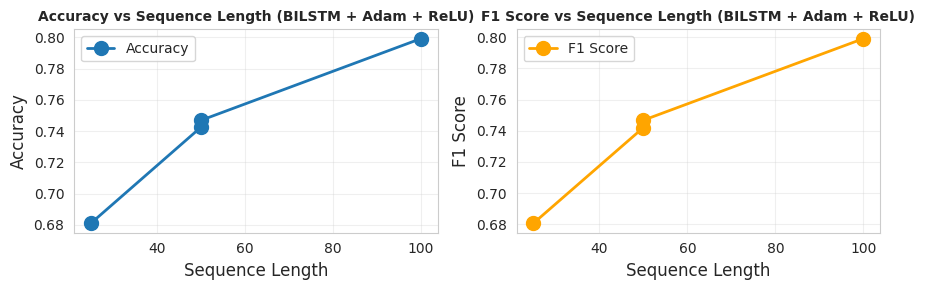

<Figure size 1500x1000 with 0 Axes>

Saved: accuracy_vs_seq_length.png


In [74]:
#Plot 1c: Accuracy vs Sequence Length
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

#Filtering data for BILSTM with Adam optimizer
seq_data = df_results[(df_results['Model'] == 'BILSTM') &
                      (df_results['Optimizer'] == 'ADAM') &
                      (df_results['Activation'] == 'relu')].sort_values('Seq_Length')

if len(seq_data) > 0:
    ax1.plot(seq_data['Seq_Length'], seq_data['Accuracy'], 'o-', linewidth=2, markersize=10, label='Accuracy')
    ax1.set_xlabel('Sequence Length', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Accuracy vs Sequence Length (BILSTM + Adam + ReLU)', fontsize=10, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.plot(seq_data['Seq_Length'], seq_data['F1'], 'o-', color='orange', linewidth=2, markersize=10, label='F1 Score')
    ax2.set_xlabel('Sequence Length', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.set_title('F1 Score vs Sequence Length (BILSTM + Adam + ReLU)', fontsize=10, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

plt.tight_layout()
plt.savefig('accuracy_vs_seq_length.png', dpi=300, bbox_inches='tight')
plt.show()

#Filtering data for BILSTM with Adam optimizer
seq_data = df_results[(df_results['Model'] == 'BILSTM') &
                      (df_results['Optimizer'] == 'ADAM') &
                      (df_results['Activation'] == 'relu')].sort_values('Seq_Length')

if len(seq_data) > 0:
    ax1.plot(seq_data['Seq_Length'], seq_data['Accuracy'], 'o-', linewidth=2, markersize=10, label='Accuracy')
    ax1.set_xlabel('Sequence Length', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Accuracy vs Sequence Length (BILSTM + Adam + ReLU)', fontsize=10, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.plot(seq_data['Seq_Length'], seq_data['F1'], 'o-', color='orange', linewidth=2, markersize=10, label='F1 Score')
    ax2.set_xlabel('Sequence Length', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.set_title('F1 Score vs Sequence Length (BILSTM + Adam + ReLU)', fontsize=10, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

plt.tight_layout()
plt.savefig('accuracy_vs_seq_length.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: accuracy_vs_seq_length.png")

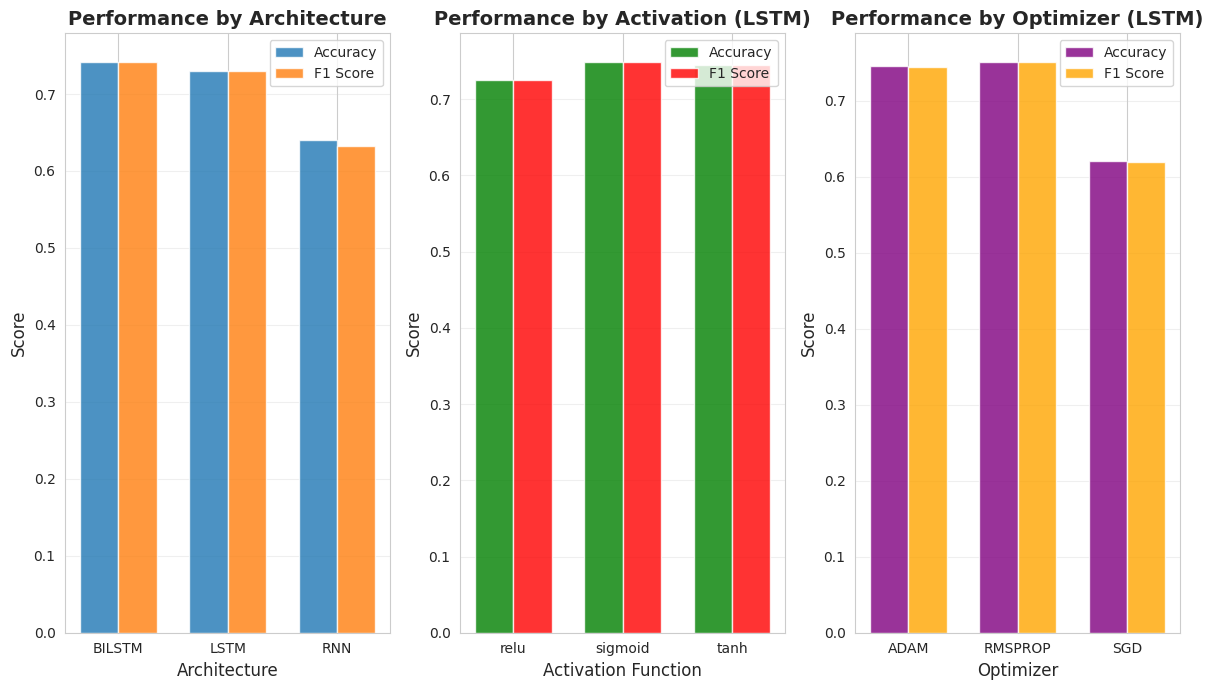


PERFORMANCE BY ARCHITECTURE
BILSTM  : Accuracy = 0.7418, F1 = 0.7416
LSTM    : Accuracy = 0.7305, F1 = 0.7302
RNN     : Accuracy = 0.6401, F1 = 0.6331

PERFORMANCE BY ACTIVATION FUNCTION (LSTM)
relu    : Accuracy = 0.7250, F1 = 0.7246
sigmoid : Accuracy = 0.7490, F1 = 0.7488
tanh    : Accuracy = 0.7451, F1 = 0.7451

PERFORMANCE BY OPTIMIZER (LSTM)
ADAM    : Accuracy = 0.7453, F1 = 0.7452
RMSPROP : Accuracy = 0.7514, F1 = 0.7512
SGD     : Accuracy = 0.6205, F1 = 0.6195

Saved: performance_comparison.png


In [57]:
#Plot 2: Architecture Comparison
fig, axes = plt.subplots(1, 3, figsize=(12, 7))

#Accuracy by Architecture
arch_comparison = df_results.groupby('Model')[['Accuracy', 'F1']].mean()
x = np.arange(len(arch_comparison.index))
width = 0.35

axes[0].bar(x - width/2, arch_comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[0].bar(x + width/2, arch_comparison['F1'], width, label='F1 Score', alpha=0.8)
axes[0].set_xlabel('Architecture', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance by Architecture', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(arch_comparison.index)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

#Activation Function Comparison
act_comparison = df_results[df_results['Model'] == 'LSTM'].groupby('Activation')[['Accuracy', 'F1']].mean()
if len(act_comparison) > 0:
    x = np.arange(len(act_comparison.index))
    axes[1].bar(x - width/2, act_comparison['Accuracy'], width, label='Accuracy', alpha=0.8, color='green')
    axes[1].bar(x + width/2, act_comparison['F1'], width, label='F1 Score', alpha=0.8, color='red')
    axes[1].set_xlabel('Activation Function', fontsize=12)
    axes[1].set_ylabel('Score', fontsize=12)
    axes[1].set_title('Performance by Activation (LSTM)', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(act_comparison.index)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

#Optimizer Comparison
opt_comparison = df_results[df_results['Model'] == 'LSTM'].groupby('Optimizer')[['Accuracy', 'F1']].mean()
if len(opt_comparison) > 0:
    x = np.arange(len(opt_comparison.index))
    axes[2].bar(x - width/2, opt_comparison['Accuracy'], width, label='Accuracy', alpha=0.8, color='purple')
    axes[2].bar(x + width/2, opt_comparison['F1'], width, label='F1 Score', alpha=0.8, color='orange')
    axes[2].set_xlabel('Optimizer', fontsize=12)
    axes[2].set_ylabel('Score', fontsize=12)
    axes[2].set_title('Performance by Optimizer (LSTM)', fontsize=14, fontweight='bold')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(opt_comparison.index)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPERFORMANCE BY ARCHITECTURE")
for model in arch_comparison.index:
    acc = arch_comparison.loc[model, 'Accuracy']
    f1 = arch_comparison.loc[model, 'F1']
    print(f"{model:8s}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")

print("\nPERFORMANCE BY ACTIVATION FUNCTION (LSTM)")
if len(act_comparison) > 0:
    for activation in act_comparison.index:
        acc = act_comparison.loc[activation, 'Accuracy']
        f1 = act_comparison.loc[activation, 'F1']
        print(f"{activation:8s}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")
else:
    print("No data available")

print("\nPERFORMANCE BY OPTIMIZER (LSTM)")
if len(opt_comparison) > 0:
    for optimizer in opt_comparison.index:
        acc = opt_comparison.loc[optimizer, 'Accuracy']
        f1 = opt_comparison.loc[optimizer, 'F1']
        print(f"{optimizer:8s}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")
else:
    print("No data available")

print("\nSaved: performance_comparison.png")

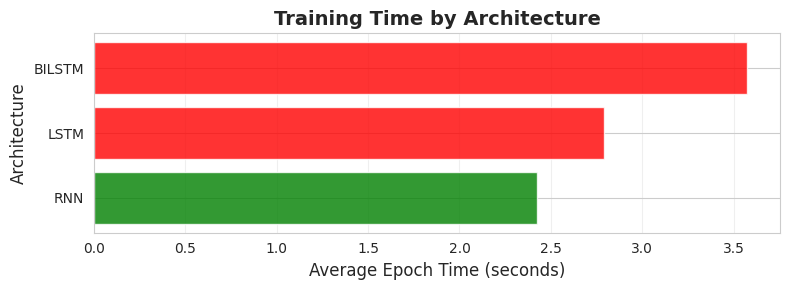


Training Time by Architecture:
RNN    : 2.42 seconds
LSTM   : 2.79 seconds
BILSTM : 3.57 seconds

Saved: training_time_comparison.png


In [52]:
#Plot 3: Training Time Comparison
fig, ax = plt.subplots(figsize=(8, 3))

time_comparison = df_results.groupby('Model')['Epoch_Time'].mean().sort_values()
colors = ['green' if x < time_comparison.median() else 'red' for x in time_comparison.values]

ax.barh(time_comparison.index, time_comparison.values, alpha=0.8, color=colors)
ax.set_xlabel('Average Epoch Time (seconds)', fontsize=12)
ax.set_ylabel('Architecture', fontsize=12)
ax.set_title('Training Time by Architecture', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('training_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTraining Time by Architecture:")
for model, time in time_comparison.items():
    print(f"{model:7s}: {time:.2f} seconds")
print("\nSaved: training_time_comparison.png")

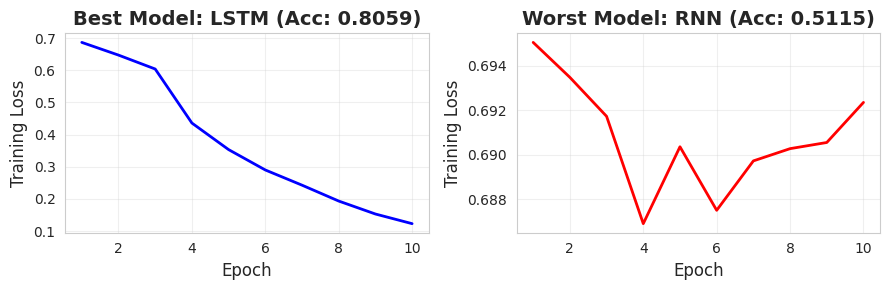


BEST MODEL CONFIGURATION:

Architecture:      LSTM
Activation:        relu
Optimizer:         ADAM
Sequence Length:   100
Gradient Clipping: No
Accuracy:          0.8059
F1 Score:          0.8058
Epoch Time:        2.92s
Final Train Loss:  0.1230

WORST MODEL CONFIGURATION:

Architecture:      RNN
Activation:        relu
Optimizer:         SGD
Sequence Length:   50
Gradient Clipping: No
Accuracy:          0.5115
F1 Score:          0.4704
Epoch Time:        2.17s
Final Train Loss:  0.6924

Saved: training_curves.png


In [76]:
#Plot 4: Training Loss Curves (Best vs Worst models)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

#Finding best and worst models
best_idx = df_results['Accuracy'].idxmax()
worst_idx = df_results['Accuracy'].idxmin()

best_result = results[best_idx]
worst_result = results[worst_idx]

#Plotting best model
epochs = range(1, len(best_result['train_losses']) + 1)
ax1.plot(epochs, best_result['train_losses'], 'b-', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title(f'Best Model: {best_result["Model"]} (Acc: {best_result["Accuracy"]:.4f})',
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

#Plotting worst model
epochs = range(1, len(worst_result['train_losses']) + 1)
ax2.plot(epochs, worst_result['train_losses'], 'r-', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Training Loss', fontsize=12)
ax2.set_title(f'Worst Model: {worst_result["Model"]} (Acc: {worst_result["Accuracy"]:.4f})',
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

#Printing configurations
print("\nBEST MODEL CONFIGURATION:\n")
print(f"Architecture:      {best_result['Model']}")
print(f"Activation:        {best_result['Activation']}")
print(f"Optimizer:         {best_result['Optimizer']}")
print(f"Sequence Length:   {best_result['Seq_Length']}")
print(f"Gradient Clipping: {best_result['Grad_Clipping']}")
print(f"Accuracy:          {best_result['Accuracy']:.4f}")
print(f"F1 Score:          {best_result['F1']:.4f}")
print(f"Epoch Time:        {best_result['Epoch_Time']:.2f}s")
print(f"Final Train Loss:  {best_result['train_losses'][-1]:.4f}")

print("\nWORST MODEL CONFIGURATION:\n")
print(f"Architecture:      {worst_result['Model']}")
print(f"Activation:        {worst_result['Activation']}")
print(f"Optimizer:         {worst_result['Optimizer']}")
print(f"Sequence Length:   {worst_result['Seq_Length']}")
print(f"Gradient Clipping: {worst_result['Grad_Clipping']}")
print(f"Accuracy:          {worst_result['Accuracy']:.4f}")
print(f"F1 Score:          {worst_result['F1']:.4f}")
print(f"Epoch Time:        {worst_result['Epoch_Time']:.2f}s")
print(f"Final Train Loss:  {worst_result['train_losses'][-1]:.4f}")

print("\nSaved: training_curves.png")

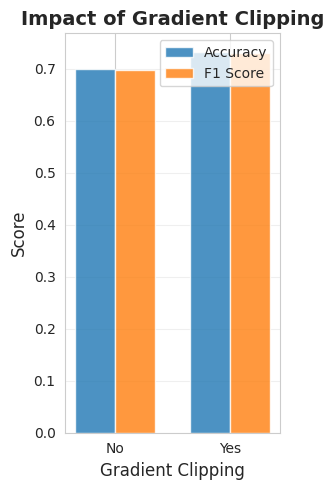


IMPACT OF GRADIENT CLIPPING:
No  : Accuracy = 0.7002, F1 = 0.6974
Yes : Accuracy = 0.7317, F1 = 0.7314

Saved: gradient_clipping_impact.png


In [65]:
#Plot 5: Gradient Clipping Impact
fig, ax = plt.subplots(figsize=(3, 5))

clip_comparison = df_results.groupby('Grad_Clipping')[['Accuracy', 'F1']].mean()
x = np.arange(len(clip_comparison.index))
width = 0.35

ax.bar(x - width/2, clip_comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x + width/2, clip_comparison['F1'], width, label='F1 Score', alpha=0.8)
ax.set_xlabel('Gradient Clipping', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Impact of Gradient Clipping', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(clip_comparison.index)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('gradient_clipping_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nIMPACT OF GRADIENT CLIPPING:")
for clip_status in clip_comparison.index:
    acc = clip_comparison.loc[clip_status, 'Accuracy']
    f1 = clip_comparison.loc[clip_status, 'F1']
    print(f"{clip_status:4s}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")

print("\nSaved: gradient_clipping_impact.png")

## 12. Hardware and Reproducibility Information

In [44]:
import platform
import psutil

print("\nHARDWARE AND REPRODUCIBILITY INFORMATION:")

print(f"\nPython Version: {platform.python_version()}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f"\nCPU: {platform.processor()}")
print(f"RAM: {psutil.virtual_memory().total / 1e9:.2f} GB")
print(f"OS: {platform.system()} {platform.release()}")

print(f"\nRandom Seed: 42")
print(f"Vocabulary Size: {VOCAB_SIZE}")
print(f"Embedding Dimension: {EMBEDDING_DIM}")
print(f"Hidden Size: {HIDDEN_SIZE}")
print(f"Number of Layers: {NUM_LAYERS}")
print(f"Dropout: {DROPOUT}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Epochs: {NUM_EPOCHS}")


HARDWARE AND REPRODUCIBILITY INFORMATION:

Python Version: 3.12.12
PyTorch Version: 2.8.0+cu126
Device: cuda
CUDA Version: 12.6
GPU: Tesla T4
GPU Memory: 15.83 GB

CPU: x86_64
RAM: 13.61 GB
OS: Linux 6.6.105+

Random Seed: 42
Vocabulary Size: 10000
Embedding Dimension: 100
Hidden Size: 64
Number of Layers: 2
Dropout: 0.4
Batch Size: 32
Number of Epochs: 10


## 13. Save All Results

In [45]:
#Saving the full results with training losses
import pickle

with open('full_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("All results saved successfully!")

All results saved successfully!
